In [1]:
import tensorflow as tf

### The Perceptron

The Perceptron is one of the simplest ANN architectures, invented in 1957 by Frank
Rosenblatt. It is based on a linear threshold unit (LTU): the inputs and output are now numbers and each input connection is associated with a weight. The LTU
computes a weighted sum of its inputs (z = w1 x1 + w2 x2 + ⋯ + wn xn = wT · x), then
applies a step function to that sum and outputs the result: hw(x) = step (z) = step (wT ·
x).

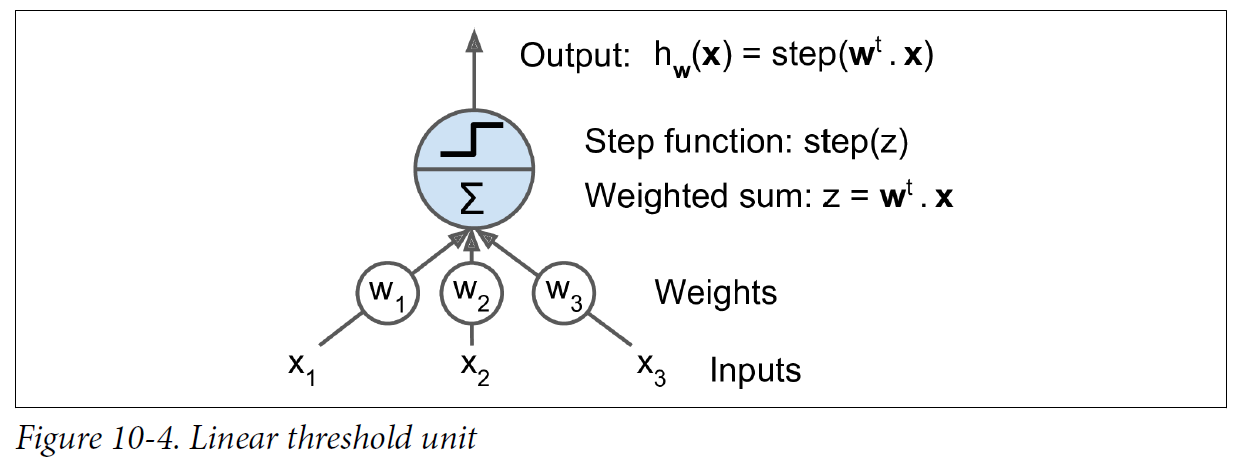

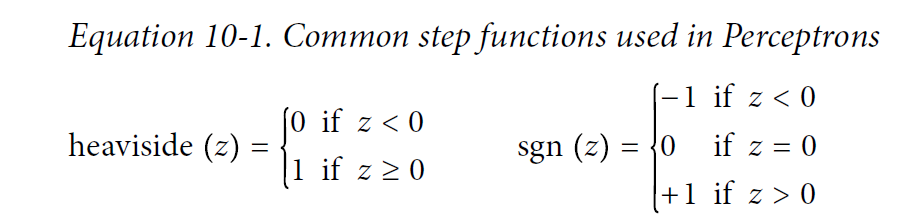

A Perceptron is simply composed of a single layer of LTUs,6 with each neuron connected
to all the inputs. These connections are often represented using special passthrough
neurons called input neurons: they just output whatever input they are fed.
Moreover, an extra bias feature is generally added (x0 = 1). This bias feature is typically
represented using a special type of neuron called a bias neuron, which just outputs
1 all the time.
A Perceptron with two inputs and three outputs is represented in Figure 10-5. This
Perceptron can classify instances simultaneously into three different binary classes,
which makes it a multioutput classifier.

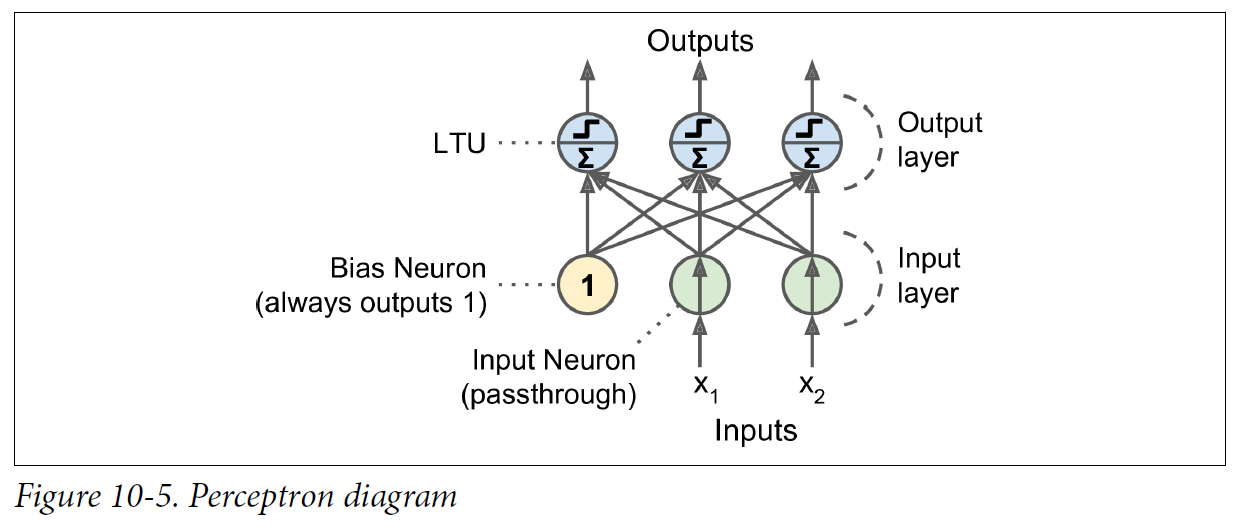

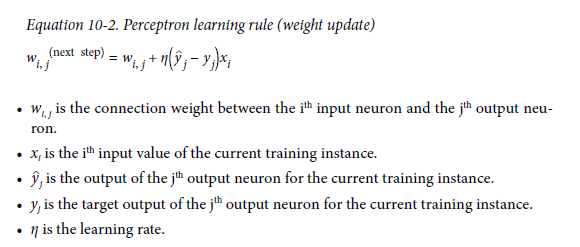

Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class
probability; rather, they just make predictions based on a hard threshold. This is one
of the good reasons to prefer Logistic Regression over Perceptrons.

### Multi-Layer Perceptron and Backpropagation
An MLP is composed of one (passthrough) input layer, one or more layers of LTUs,
called hidden layers, and one final layer of LTUs called the output layer (see
Figure 10-7). Every layer except the output layer includes a bias neuron and is fully
connected to the next layer. When an ANN has two or more hidden layers, it is called
a deep neural network (DNN).

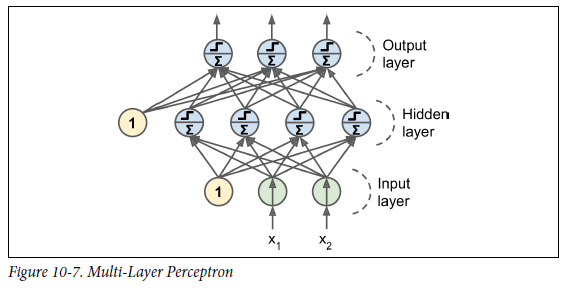

#### Backpropagation

For each training instance, the algorithm feeds it to the network and computes the
output of every neuron in each consecutive layer (this is the forward pass, just like
when making predictions). Then it measures the network’s output error (i.e., the difference
between the desired output and the actual output of the network), and it
computes how much each neuron in the last hidden layer contributed to each output
neuron’s error. It then proceeds to measure how much of these error contributions
came from each neuron in the previous hidden layer—and so on until the algorithm
reaches the input layer. This reverse pass efficiently measures the error gradient
across all the connection weights in the network by propagating the error gradient
backward in the network (hence the name of the algorithm). If you check out the reverse-mode autodiff algorithm in Appendix D, you will find that the forward and
reverse passes of backpropagation simply perform reverse-mode autodiff. The last
step of the backpropagation algorithm is a Gradient Descent step on all the connection
weights in the network, using the error gradients measured earlier.
Let’s make this even shorter: for each training instance the backpropagation algorithm
first makes a prediction (forward pass), measures the error, then goes through
each layer in reverse to measure the error contribution from each connection (reverse
pass), and finally slightly tweaks the connection weights to reduce the error (Gradient
Descent step).

In order for this algorithm to work properly, the authors made a key change to the
MLP’s architecture: they replaced the step function with the logistic function, σ(z) =
1 / (1 + exp(–z)). This was essential because the step function contains only flat segments,
so there is no gradient to work with (Gradient Descent cannot move on a flat
surface), while the logistic function has a well-defined nonzero derivative everywhere,
allowing Gradient Descent to make some progress at every step. The backpropagation
algorithm may be used with other activation functions, instead of the logistic
function. Two other popular activation functions are:    

The hyperbolic tangent function tanh (z) = 2σ(2z) – 1
Just like the logistic function it is S-shaped, continuous, and differentiable, but its
output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function),
which tends to make each layer’s output more or less normalized (i.e., centered
around 0) at the beginning of training. This often helps speed up
convergence.
The ReLU function (introduced in Chapter 9)
ReLU (z) = max (0, z). It is continuous but unfortunately not differentiable at z =
0 (the slope changes abruptly, which can make Gradient Descent bounce
around). However, in practice it works very well and has the advantage of being
fast to compute. Most importantly, the fact that it does not have a maximum output
value also helps reduce some issues during Gradient Descent (we will come
back to this in Chapter 11).

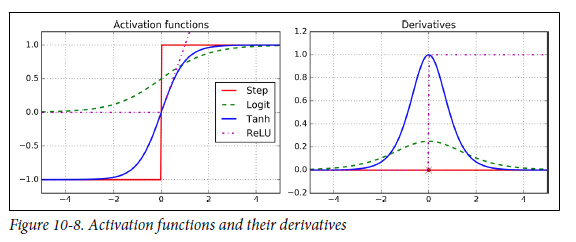

In order for this algorithm to work properly, the authors made a key change to the
MLP’s architecture: they replaced the step function with the logistic function, σ(z) =
1 / (1 + exp(–z)). This was essential because the step function contains only flat segments,
so there is no gradient to work with (Gradient Descent cannot move on a flat
surface), while the logistic function has a well-defined nonzero derivative everywhere,
allowing Gradient Descent to make some progress at every step. The backpropagation
algorithm may be used with other activation functions, instead of the logistic
function. Two other popular activation functions are:    

The hyperbolic tangent function tanh (z) = 2σ(2z) – 1
Just like the logistic function it is S-shaped, continuous, and differentiable, but its
output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function),
which tends to make each layer’s output more or less normalized (i.e., centered
around 0) at the beginning of training. This often helps speed up
convergence.
The ReLU function (introduced in Chapter 9)
ReLU (z) = max (0, z). It is continuous but unfortunately not differentiable at z =
0 (the slope changes abruptly, which can make Gradient Descent bounce
around). However, in practice it works very well and has the advantage of being
fast to compute. Most importantly, the fact that it does not have a maximum output
value also helps reduce some issues during Gradient Descent (we will come
back to this in Chapter 11).

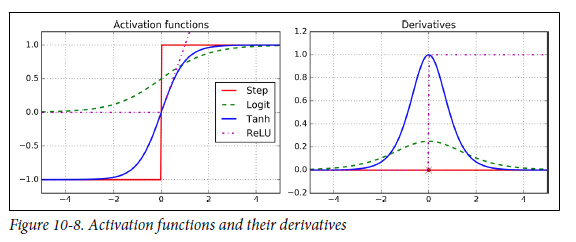

An MLP is often used for classification, with each output corresponding to a different
binary class (e.g., spam/ham, urgent/not-urgent, and so on). When the classes are
exclusive (e.g., classes 0 through 9 for digit image classification), the output layer is
typically modified by replacing the individual activation functions by a shared softmax
function (see Figure 10-9). The softmax function was introduced in Chapter 3.
The output of each neuron corresponds to the estimated probability of the corresponding
class. Note that the signal flows only in one direction (from the inputs to
the outputs), so this architecture is an example of a feedforward neural network
(FNN).

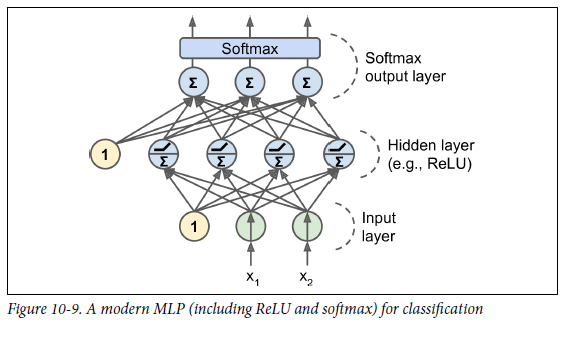

#### Training a DNN Using Plain TensorFlow

low level:

In [4]:
import tensorflow as tf
import numpy as np

n_inputs = 28*28 # MNIST pixels

# neurons in each layer
n_hidden1 = 300 
n_hidden2 = 100
n_outputs = 10

# placeholders to represent input and output
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") #input layer
y = tf.placeholder(tf.int64, shape=(None), name="y") # output layer

# create hidden layers
def neuron_layer(X, n_neurons, name, activation=None):
    # function used to create one layer at a time
    with tf.name_scope(name): # scope with layer name (for tboard)
        n_inputs = int(X.get_shape()[1]) # number features input
        # create weight matrix (variable).
        # conect each input and each neuron. Size=n_inputs, n_neurons
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        # create bias (variable) initialized to 0
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        # subgraph to compute z
        z = tf.matmul(X, W) + b
        # return relu if activation is relu. Otherwise z
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

# use function to create deep neural network:
#the first hidden layer takes X as its input. 
#the second takes the output of the first hidden layer as its input.
#the output layer takes the output of the second hidden layer as its input.
with tf.name_scope("dnn"): # name scope for clarity (optional)
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, n_outputs, "outputs")

high level:

As you might expect, TensorFlow comes with many handy functions to create
standard neural network layers, so there’s often no need to define your own
neuron_layer() function like we just did. For example, TensorFlow’s fully_connec
ted() function creates a fully connected layer, where all the inputs are connected to
all the neurons in the layer. It takes care of creating the weights and biases variables,
with the proper initialization strategy, and it uses the ReLU activation function by
default (we can change this using the activation_fn argument). As we will see in
Chapter 11, it also supports regularization and normalization parameters. Let’s tweak
the preceding code to use the fully_connected() function instead of our neu
ron_layer() function. Simply import the function and replace the dnn construction
section with the following code:

In [ ]:
from tensorflow.contrib.layers import fully_connected
with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs",
    activation_fn=None)

Now that we have the neural network model ready to go, we need to define the cost
function that we will use to train it. Just as we did for Softmax Regression in Chapter
4, we will use cross entropy. As we discussed earlier, cross entropy will penalize
models that estimate a low probability for the target class. TensorFlow provides
several functions to compute cross entropy. We will use sparse_soft
max_cross_entropy_with_logits(): it computes the cross entropy based on the
“logits” (i.e., the output of the network before going through the softmax activation
function), and it expects labels in the form of integers ranging from 0 to the number
of classes minus 1 (in our case, from 0 to 9). This will give us a 1D tensor containing
the cross entropy for each instance. We can then use TensorFlow’s reduce_mean()
function to compute the mean cross entropy over all instances.

The sparse_softmax_cross_entropy_with_logits() function is
equivalent to applying the softmax activation function and then
computing the cross entropy, but it is more efficient, and it properly
takes care of corner cases like logits equal to 0. This is why we
did not apply the softmax activation function earlier. There is also
another function called softmax_cross_entropy_with_logits(),
which takes labels in the form of one-hot vectors (instead of ints
from 0 to the number of classes minus 1).

In [5]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

We have the neural network model, we have the cost function, and now we need to
define a GradientDescentOptimizer that will tweak the model parameters to minimize
the cost function.

In [6]:
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The last important step in the construction phase is to specify how to evaluate the
model. We will simply use accuracy as our performance measure. First, for each
instance, determine if the neural network’s prediction is correct by checking whether
or not the highest logit corresponds to the target class. For this you can use the
in_top_k() function. This returns a 1D tensor full of boolean values, so we need to
cast these booleans to floats and then compute the average. This will give us the network’s
overall accuracy.

In [7]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

And, as usual, we need to create a node to initialize all variables, and we will also create
a Saver to save our trained model parameters to disk:

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Phew! This concludes the construction phase. This was fewer than 40 lines of code,
but it was pretty intense: we created placeholders for the inputs and the targets, we
created a function to build a neuron layer, we used it to create the DNN, we defined
the cost function, we created an optimizer, and finally we defined the performance
measure. Now on to the execution phase.

#### Execution Phase
This part is much shorter and simpler. First, let’s load MNIST. We could use Scikit-
Learn for that as we did in previous chapters, but TensorFlow offers its own helper
that fetches the data, scales it (between 0 and 1), shuffles it, and provides a simple
function to load one mini-batches a time. So let’s use it instead:

Now we define the number of epochs that we want to run, as well as the size of the
mini-batches:

And now we can train the model:

This code opens a TensorFlow session, and it runs the init node that initializes all
the variables. Then it runs the main training loop: at each epoch, the code iterates
through a number of mini-batches that corresponds to the training set size. Each
mini-batch is fetched via the next_batch() method, and then the code simply runs
the training operation, feeding it the current mini-batch input data and targets. Next,
at the end of each epoch, the code evaluates the model on the last mini-batch and on
the full training set, and it prints out the result. Finally, the model parameters are
saved to disk.
Training

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

n_epochs = 400
batch_size = 50

#open session
with tf.Session() as sess:
    #initialize variables
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./my_model_final.ckpt")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.94 Test accuracy: 0.9104
1 Train accuracy: 0.94 Test accuracy: 0.9302
2 Train accuracy: 0.92 Test accuracy: 0.942
3 Train accuracy: 0.92 Test accuracy: 0.946
4 Train accuracy: 0.96 Test accuracy: 0.9517
5 Train accuracy: 0.98 Test accuracy: 0.9554
6 Train accuracy: 0.96 Test accuracy: 0.9563
7 Train accuracy: 0.96 Test accuracy: 0.9593
8 Train accuracy: 0.98 Test accuracy: 0.962
9 Train accuracy: 1.0 Test accuracy: 0.9647
10 Train accuracy: 0.98 Test accuracy: 0.9667
11 Train accuracy: 1.0 Test accuracy: 0.9677
12 Train accurac

171 Train accuracy: 1.0 Test accuracy: 0.981
172 Train accuracy: 1.0 Test accuracy: 0.9809
173 Train accuracy: 1.0 Test accuracy: 0.9808
174 Train accuracy: 1.0 Test accuracy: 0.9805
175 Train accuracy: 1.0 Test accuracy: 0.9807
176 Train accuracy: 1.0 Test accuracy: 0.9808
177 Train accuracy: 1.0 Test accuracy: 0.9808
178 Train accuracy: 1.0 Test accuracy: 0.9807
179 Train accuracy: 1.0 Test accuracy: 0.9809
180 Train accuracy: 1.0 Test accuracy: 0.9807
181 Train accuracy: 1.0 Test accuracy: 0.981
182 Train accuracy: 1.0 Test accuracy: 0.9811
183 Train accuracy: 1.0 Test accuracy: 0.9808
184 Train accuracy: 1.0 Test accuracy: 0.981
185 Train accuracy: 1.0 Test accuracy: 0.9808
186 Train accuracy: 1.0 Test accuracy: 0.9809
187 Train accuracy: 1.0 Test accuracy: 0.9811
188 Train accuracy: 1.0 Test accuracy: 0.9808
189 Train accuracy: 1.0 Test accuracy: 0.9807
190 Train accuracy: 1.0 Test accuracy: 0.9809
191 Train accuracy: 1.0 Test accuracy: 0.9808
192 Train accuracy: 1.0 Test accuracy

350 Train accuracy: 1.0 Test accuracy: 0.9806
351 Train accuracy: 1.0 Test accuracy: 0.9807
352 Train accuracy: 1.0 Test accuracy: 0.9807
353 Train accuracy: 1.0 Test accuracy: 0.9808
354 Train accuracy: 1.0 Test accuracy: 0.9807
355 Train accuracy: 1.0 Test accuracy: 0.9806
356 Train accuracy: 1.0 Test accuracy: 0.9807
357 Train accuracy: 1.0 Test accuracy: 0.9808
358 Train accuracy: 1.0 Test accuracy: 0.9808
359 Train accuracy: 1.0 Test accuracy: 0.9807
360 Train accuracy: 1.0 Test accuracy: 0.9806
361 Train accuracy: 1.0 Test accuracy: 0.9806
362 Train accuracy: 1.0 Test accuracy: 0.9807
363 Train accuracy: 1.0 Test accuracy: 0.9808
364 Train accuracy: 1.0 Test accuracy: 0.9808
365 Train accuracy: 1.0 Test accuracy: 0.9807
366 Train accuracy: 1.0 Test accuracy: 0.9807
367 Train accuracy: 1.0 Test accuracy: 0.9809
368 Train accuracy: 1.0 Test accuracy: 0.9807
369 Train accuracy: 1.0 Test accuracy: 0.9809
370 Train accuracy: 1.0 Test accuracy: 0.9807
371 Train accuracy: 1.0 Test accur

Using the Neural Network
Now that the neural network is trained, you can use it to make predictions. To do
that, you can reuse the same construction phase, but change the execution phase like
this:

First the code loads the model parameters from disk. Then it loads some new images
that you want to classify. Remember to apply the same feature scaling as for the training
data (in this case, scale it from 0 to 1). Then the code evaluates the logits node.
If you wanted to know all the estimated class probabilities, you would need to apply
the softmax() function to the logits, but if you just want to predict a class, you can
simply pick the class that has the highest logit value (using the argmax() function
does the trick).

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    X_new_scaled = [...] # some new images (scaled from 0 to 1)
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

#### Fine-Tuning Neural Network Hyperparameters
The flexibility of neural networks is also one of their main drawbacks: there are many
hyperparameters to tweak. Not only can you use any imaginable network topology
(how neurons are interconnected), but even in a simple MLP you can change the
number of layers, the number of neurons per layer, the type of activation function to
use in each layer, the weight initialization logic, and much more. How do you know
what combination of hyperparameters is the best for your task?
Of course, you can use grid search with cross-validation to find the right hyperparameters,
like you did in previous chapters, but since there are many hyperparameters
to tune, and since training a neural network on a large dataset takes a lot of time, you
will only be able to explore a tiny part of the hyperparameter space in a reasonable
amount of time. It is much better to use randomized search, as we discussed in Chapter
2. Another option is to use a tool such as Oscar, which implements more complex
algorithms to help you find a good set of hyperparameters quickly.
It helps to have an idea of what values are reasonable for each hyperparameter, so you
can restrict the search space. Let’s start with the number of hidden layers.

#### Number of Hidden Layers
For many problems, you can just begin with a single hidden layer and you will get
reasonable results. It has actually been shown that an MLP with just one hidden layer
can model even the most complex functions provided it has enough neurons. For a
long time, these facts convinced researchers that there was no need to investigate any
deeper neural networks. But they overlooked the fact that deep networks have a much
higher parameter efficiency than shallow ones: they can model complex functions
using exponentially fewer neurons than shallow nets, making them much faster to
train.
To understand why, suppose you are asked to draw a forest using some drawing software,
but you are forbidden to use copy/paste. You would have to draw each tree
individually, branch per branch, leaf per leaf. If you could instead draw one leaf,
copy/paste it to draw a branch, then copy/paste that branch to create a tree, and
finally copy/paste this tree to make a forest, you would be finished in no time. Realworld
data is often structured in such a hierarchical way and DNNs automatically
take advantage of this fact: lower hidden layers model low-level structures (e.g., line
segments of various shapes and orientations), intermediate hidden layers combine
these low-level structures to model intermediate-level structures (e.g., squares, circles),
and the highest hidden layers and the output layer combine these intermediate
structures to model high-level structures (e.g., faces).

Not only does this hierarchical architecture help DNNs converge faster to a good solution,
it also improves their ability to generalize to new datasets. For example, if you
have already trained a model to recognize faces in pictures, and you now want to
train a new neural network to recognize hairstyles, then you can kickstart training by
reusing the lower layers of the first network. Instead of randomly initializing the
weights and biases of the first few layers of the new neural network, you can initialize
them to the value of the weights and biases of the lower layers of the first network.
This way the network will not have to learn from scratch all the low-level structures
that occur in most pictures; it will only have to learn the higher-level structures (e.g.,
hairstyles).
In summary, for many problems you can start with just one or two hidden layers and
it will work just fine (e.g., you can easily reach above 97% accuracy on the MNIST
dataset using just one hidden layer with a few hundred neurons, and above 98% accuracy
using two hidden layers with the same total amount of neurons, in roughly the
same amount of training time). For more complex problems, you can gradually ramp
up the number of hidden layers, until you start overfitting the training set. Very complex
tasks, such as large image classification or speech recognition, typically require
networks with dozens of layers (or even hundreds, but not fully connected ones, as
we will see in Chapter 13), and they need a huge amount of training data. However,
you will rarely have to train such networks from scratch: it is much more common to
reuse parts of a pretrained state-of-the-art network that performs a similar task.
Training will be a lot faster and require much less data (we will discuss this in Chapter
11).

#### Number of Neurons per Hidden Layer
Obviously the number of neurons in the input and output layers is determined by the
type of input and output your task requires. For example, the MNIST task requires 28
x 28 = 784 input neurons and 10 output neurons. As for the hidden layers, a common
practice is to size them to form a funnel, with fewer and fewer neurons at each layer—
the rationale being that many low-level features can coalesce into far fewer high-level
features. For example, a typical neural network for MNIST may have two hidden layers,
the first with 300 neurons and the second with 100. However, this practice is not
as common now, and you may simply use the same size for all hidden layers—for
example, all hidden layers with 150 neurons: that’s just one hyperparameter to tune
instead of one per layer. Just like for the number of layers, you can try increasing the
number of neurons gradually until the network starts overfitting. In general you will
get more bang for the buck by increasing the number of layers than the number of
neurons per layer. Unfortunately, as you can see, finding the perfect amount of neurons
is still somewhat of a black art.
A simpler approach is to pick a model with more layers and neurons than you
actually need, then use early stopping to prevent it from overfitting (and other regularization
techniques, especially dropout, as we will see in Chapter 11). This has been
dubbed the “stretch pants” approach:12 instead of wasting time looking for pants that
perfectly match your size, just use large stretch pants that will shrink down to the
right size.

#### Activation Functions
In most cases you can use the ReLU activation function in the hidden layers (or one
of its variants, as we will see in Chapter 11). It is a bit faster to compute than other
activation functions, and Gradient Descent does not get stuck as much on plateaus,
thanks to the fact that it does not saturate for large input values (as opposed to the
logistic function or the hyperbolic tangent function, which saturate at 1).
For the output layer, the softmax activation function is generally a good choice for
classification tasks (when the classes are mutually exclusive). For regression tasks,
you can simply use no activation function at all.
This concludes this introduction to artificial neural networks. In the following chapters,
we will discuss techniques to train very deep nets, and distribute training across
multiple servers and GPUs. Then we will explore a few other popular neural network
architectures: convolutional neural networks, recurrent neural networks, and autoencoders.
13